# Decision Tree and Logistic Regression

The notebook demonstrates the model *DecisionTreeLogisticRegression* which replaces the decision based on one variable by a logistic regression.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Iris dataset and logistic regression

The following code shows the border defined by two machine learning models on the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html).

In [3]:
import numpy
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


def plot_classifier_decision_zone(clf, X, y, title=None, ax=None):
    
    if ax is None:
        ax = plt.gca()
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    dhx = (x_max - x_min) / 100
    dhy = (y_max - y_min) / 100
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, dhx),
                            numpy.arange(y_min, y_max, dhy))

    Z = clf.predict(numpy.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.5)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', lw=0.5)
    if title is not None:
        ax.set_title(title)

        
iris = load_iris()
X = iris.data[:, [0, 2]]
y = iris.target
y = y % 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, shuffle=True)

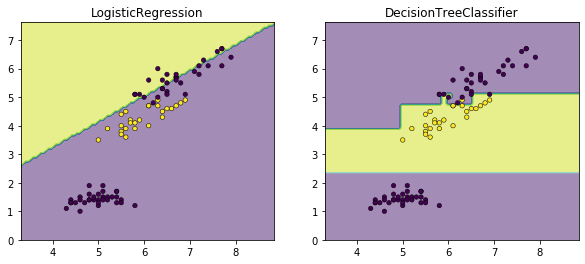

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

lr = LogisticRegression()
lr.fit(X_train, y_train)

dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, y_train)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_classifier_decision_zone(lr, X_test, y_test, ax=ax[0], title="LogisticRegression")
plot_classifier_decision_zone(dt, X_test, y_test, ax=ax[1], title="DecisionTreeClassifier")

## Gini, information gain, likelihood

These criteria are used to select threshold in a decision tree. Let's how they behave in two cases, one easy for a linear model, one impossible for a linear model.

In [5]:
from pandas import DataFrame


def random_set_1d(n, kind):
    x = numpy.random.rand(n) * 3 - 1
    if kind:
        y = numpy.empty(x.shape, dtype=numpy.int32)
        y[x < 0] = 0
        y[(x >= 0) & (x <= 1)] = 1
        y[x > 1] = 0
    else:
        y = numpy.empty(x.shape, dtype=numpy.int32)
        y[x < 0] = 0
        y[x >= 0] = 1
    x2 = numpy.random.rand(n)
    return numpy.vstack([x, x2]).T, y


def plog2(p):
    if p == 0:
        return 0
    return p * numpy.log(p) / numpy.log(2)


def logistic(x):
    return 1. / (1. + numpy.exp(-x))


def likelihood(x, y, theta=1., th=0.):
    lr = logistic((x - th) * theta)
    return y * lr + (1. - y) * (1 - lr)


def criteria(X, y):    
    res = numpy.empty((X.shape[0], 8))
    res[:, 0] = X[:, 0]
    res[:, 1] = y
    order = numpy.argsort(res[:, 0])
    res = res[order, :].copy()
    x = res[:, 0].copy()
    y = res[:, 1].copy()
    
    for i in range(1, res.shape[0]-1):
        # gini
        p1 = numpy.sum(y[:i]) / i
        p2 = numpy.sum(y[i:]) / (y.shape[0] - i)
        res[i, 2] = p1
        res[i, 3] = p2
        res[i, 4] = 1 - p1**2 - (1-p1)**2 + 1 - p2**2 - (1-p2)**2
        res[i, 5] = - plog2(p1) - plog2(1-p1) - plog2(p2) - plog2(1-p2)
        th = x[i]
        res[i, 6] = logistic(th * 10.)
        res[i, 7] = numpy.sum(likelihood(x, y, 10., th)) / res.shape[0]
    return DataFrame(res[1:-1], columns=['X', 'y', 'p1', 'p2', 'Gini', 'Gain', 'lr', 'LL-10'])


X1, y1 = random_set_1d(1000, False)
X2, y2 = random_set_1d(1000, True)

df = criteria(X1, y1)
df.head()

,X,y,p1,p2,Gini,Gain,lr,LL-10
0,-0.996617,0.0,0.0,0.638639,0.461559,0.943807,0.000047,0.663405
1,-0.994459,0.0,0.0,0.639279,0.461203,0.943280,0.000048,0.663793
2,-0.992360,0.0,0.0,0.639920,0.460845,0.942750,0.000049,0.664175
3,-0.991520,0.0,0.0,0.640562,0.460485,0.942215,0.000049,0.664328
4,-0.988552,0.0,0.0,0.641206,0.460122,0.941678,0.000051,0.664876


In [6]:
df.tail()

,X,y,p1,p2,Gini,Gain,lr,LL-10
993,1.976924,1.0,0.635815,1.0,0.463109,0.946102,1.0,0.384136
994,1.980107,1.0,0.636181,1.0,0.462910,0.945808,1.0,0.383647
995,1.980558,1.0,0.636546,1.0,0.462710,0.945513,1.0,0.383579
996,1.985548,1.0,0.636911,1.0,0.462511,0.945218,1.0,0.382830
997,1.989164,1.0,0.637275,1.0,0.462311,0.944922,1.0,0.382298


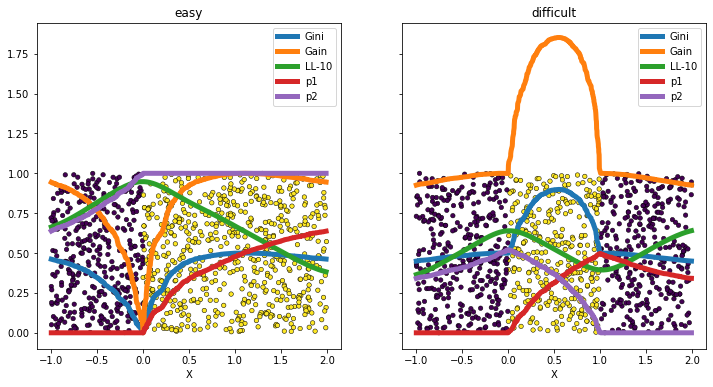

In [7]:
def plot_ds(X, y, ax=None, title=None):
    if ax is None:
        ax = plt.gca()    
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', lw=0.5)
    if title is not None:
        ax.set_title(title)
    return ax


df1 = criteria(X1, y1)
df2 = criteria(X2, y2)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plot_ds(X1, y1, ax=ax[0], title="easy")
plot_ds(X2, y2, ax=ax[1], title="difficult")
df1.plot(x='X', y=['Gini', 'Gain', 'LL-10', 'p1', 'p2'], ax=ax[0], lw=5.)
df2.plot(x='X', y=['Gini', 'Gain', 'LL-10', 'p1', 'p2'], ax=ax[1], lw=5.);

This grph shows that the [Gini coefficient](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity), the information gain or the likelihood easily pick up the right decision in the first case, an easy linear case. In the second one, there is no linear border between the two classes. A decision tree does require at least two nodes to to be successful in the decision, exactly two nodes if the model can catch the two borders but none of the indicators seems to be able to pick up one border.

## DecisionTreeLogisticRegression

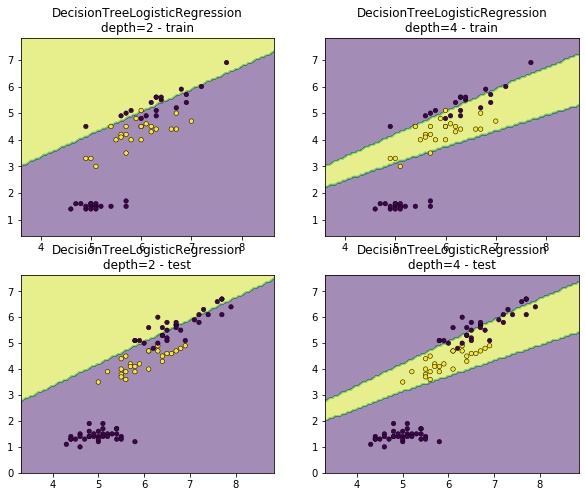

In [8]:
from mlinsights.mlmodel import DecisionTreeLogisticRegression

dtlr = DecisionTreeLogisticRegression(
    estimator=LogisticRegression(solver='liblinear'),
    min_samples_leaf=10, min_samples_split=10, max_depth=1)
dtlr.fit(X_train, y_train)
dtlr2 = DecisionTreeLogisticRegression(
    estimator=LogisticRegression(solver='liblinear'),
    min_samples_leaf=4, min_samples_split=4, max_depth=10)
dtlr2.fit(X_train, y_train)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
plot_classifier_decision_zone(
    dtlr, X_train, y_train, ax=ax[0, 0],
    title="DecisionTreeLogisticRegression\ndepth=%d - train" % dtlr.tree_depth_)
plot_classifier_decision_zone(
    dtlr2, X_train, y_train, ax=ax[0, 1],
    title="DecisionTreeLogisticRegression\ndepth=%d - train" % dtlr2.tree_depth_)
plot_classifier_decision_zone(
    dtlr, X_test, y_test, ax=ax[1, 0],
    title="DecisionTreeLogisticRegression\ndepth=%d - test" % dtlr.tree_depth_)
plot_classifier_decision_zone(
    dtlr2, X_test, y_test, ax=ax[1, 1],
    title="DecisionTreeLogisticRegression\ndepth=%d - test" % dtlr2.tree_depth_)

In [9]:
from pandas import DataFrame

rows = []
for model in [lr, dt, dtlr, dtlr2]:
    val = (" - depth=%d" % model.tree_depth_) if hasattr(model, 'tree_depth_') else ""
    obs = dict(name="%s%s" % (model.__class__.__name__, val),
               score=model.score(X_test, y_test))
    rows.append(obs)

DataFrame(rows)

,name,score
0,LogisticRegression,0.544444
1,DecisionTreeClassifier,0.955556
2,DecisionTreeLogisticRegression - depth=2,0.533333
3,DecisionTreeLogisticRegression - depth=4,0.833333
